## Finding insides from AirBnB in Berlin

In this project I used the [Cross Industry Process](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) for Data Mining on the [Berlin AirBnB dataset](http://insideairbnb.com/get-the-data.html). I hope this project will give you some valuable insides for Berlin.

The CRISP-DM process can be broken down into several steps which help understanding the problem

- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results
- Deploy


In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from support import *

plt.style.use('ggplot')  # графики
plt.rcParams['figure.figsize'] = (16, 10)  # Размер картинок



In [2]:
# Read the data
listings = pd.read_csv('data/listings.csv.gz', low_memory=False, compression="gzip")

### Determine the number of rows (entries for specifc accommodations) and columns (different features of the accommodations)

In [ ]:
# Checking the shape of the listings dataset
print('The dataset contains', listings.shape[0], 'rows and', listings.shape[1], 'columns.')

In [ ]:
# Show all cols in the head
pd.options.display.max_columns = listings.shape[1]
listings.describe()

In [ ]:
# Data owerview 
col_check(listings)

In [ ]:
# Check the missing values
show_missing(listings)

In [ ]:
#Provide a set of column name that have no values and must be dropped
listings.columns[listings.isnull().mean() == 1]

In [ ]:
#Provide a set of column name that have some missing values
listings.columns[listings.isnull().mean() > 0]

In [ ]:
#Provide a set of column name without missing values
listings.columns[listings.isnull().mean() == 0]

In [ ]:
# Check the data structure
listings.dtypes.value_counts()

In [ ]:
# list of all colums
listings.columns.tolist()

In [ ]:
listings.groupby(['neighbourhood_group_cleansed']).count()

## Prepare Data

decide on the data that we are going to use for our analysis. 

In [3]:
# Define a subset of the original Listing dataset
ss = listings[['id','price', 'property_type', 'bedrooms', 'minimum_nights',
               'number_of_reviews', 'reviews_per_month','review_scores_value', 'review_scores_rating', 'availability_365','availability_90', 'availability_60', 'availability_30']]

# Use only appartments
ss = ss[ss['property_type']=='Apartment']

# drop property_type
ss = ss.drop(columns=['property_type'])

In [4]:
#Drop missing values in rows
ss.dropna(axis=0)

id    price  bedrooms  minimum_nights  number_of_reviews  \
0          1944   $21.00       1.0              60                 18   
1          3176   $90.00       1.0              62                145   
2          3309   $28.00       1.0               7                 27   
4          7071   $33.00       1.0               3                266   
5          9991  $180.00       4.0               6                  7   
...         ...      ...       ...             ...                ...   
24394  39868831   $70.00       0.0               1                  1   
24399  39879765   $50.00       2.0               2                  1   
24404  39883210   $40.00       1.0               1                  2   
24456  39942426   $20.00       1.0               1                  1   
24459  39947024   $25.00       1.0               1                  2   

       reviews_per_month  review_scores_value  review_scores_rating  \
0                   0.24                  8.0                  82.0   
1                   1.14                  9.0                  93.0   
2                   0.35                  9.0                  89.0   
4                   2.13                 10.0                  96.0   
5                   0.13                 10.0                 100.0   
...                  ...                  ...                   ...   
24394               1.00                 10.0                 100.0   
24399               1.00                 10.0                 100.0   
24404               2.00                  8.0                 100.0   
24456               1.00                 10.0                 100.0   
24459               2.00                 10.0                  60.0   

       availability_365  availability_90  availability_60  availability_30  
0                   251               25               25                9  
1                   344               69               39                9  
2                   317               42               12                0  
4                    30               30               30               21  
5                    45                8                1                0  
...                 ...              ...              ...              ...  
24394                87               87               57               30  
24399                70               70               40               15  
24404               358               83               53               24  
24456                53               53               27               14  
24459                 0                0                0                0  

[17759 rows x 12 columns]

In [5]:
# Clearing the price

# ss = ss.replace({'price': r'\$(\d{,3})\,?(\d{,3})\.*(\d{,3})'}, {'price': r'\1\2'}, regex=True)
# ss.price = ss['price'].astype(int)

ss['price'] = ss['price'].str.replace(',', '')
ss['price'] = ss['price'].str.replace('$', '')
ss['price'] = ss['price'].astype(float)
ss['price'].describe()


count    21849.000000
mean        61.782461
std         91.428355
min          0.000000
25%         33.000000
50%         49.000000
75%         75.000000
max       9000.000000
Name: price, dtype: float64

In [ ]:
#Price values destributon
ss.price.value_counts(normalize = True, bins = 20)

In [ ]:
ss.loc[(ss.price <= 450) & (ss.price > 0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices');


In [6]:
# Remowe all prices higher then 450
ss = ss[ss['price'] <= 450]

In [ ]:
ss.head()

In [7]:
# Add boolean values
boolean_feature = ['host_identity_verified', 'instant_bookable', 'host_is_superhost', 'is_business_travel_ready']
for i in boolean_feature:
    ss[i] = listings[i].map({'t': True, 'f': False})
ss.head()

id  price  bedrooms  minimum_nights  number_of_reviews  \
0  1944   21.0       1.0              60                 18   
1  3176   90.0       1.0              62                145   
2  3309   28.0       1.0               7                 27   
4  7071   33.0       1.0               3                266   
5  9991  180.0       4.0               6                  7   

   reviews_per_month  review_scores_value  review_scores_rating  \
0               0.24                  8.0                  82.0   
1               1.14                  9.0                  93.0   
2               0.35                  9.0                  89.0   
4               2.13                 10.0                  96.0   
5               0.13                 10.0                 100.0   

   availability_365  availability_90  availability_60  availability_30  \
0               251               25               25                9   
1               344               69               39                9   
2               317               42               12                0   
4                30               30               30               21   
5                45                8                1                0   

  host_identity_verified  instant_bookable host_is_superhost  \
0                   True             False             False   
1                   True             False             False   
2                  False             False             False   
4                   True             False              True   
5                   True             False             False   

   is_business_travel_ready  
0                     False  
1                     False  
2                     False  
4                     False  
5                     False

In [8]:
# Cancelation policy cleaning
ss = pd.concat([ss, pd.get_dummies(listings['cancellation_policy'])],axis=1)
ss.head()

id  price  bedrooms  minimum_nights  number_of_reviews  \
0  1944.0   21.0       1.0            60.0               18.0   
1  3176.0   90.0       1.0            62.0              145.0   
2  3309.0   28.0       1.0             7.0               27.0   
3     NaN    NaN       NaN             NaN                NaN   
4  7071.0   33.0       1.0             3.0              266.0   

   reviews_per_month  review_scores_value  review_scores_rating  \
0               0.24                  8.0                  82.0   
1               1.14                  9.0                  93.0   
2               0.35                  9.0                  89.0   
3                NaN                  NaN                   NaN   
4               2.13                 10.0                  96.0   

   availability_365  availability_90  ...  host_identity_verified  \
0             251.0             25.0  ...                    True   
1             344.0             69.0  ...                    True   
2             317.0             42.0  ...                   False   
3               NaN              NaN  ...                     NaN   
4              30.0             30.0  ...                    True   

   instant_bookable host_is_superhost is_business_travel_ready flexible  \
0             False             False                    False        0   
1             False             False                    False        0   
2             False             False                    False        0   
3               NaN               NaN                      NaN        0   
4             False              True                    False        0   

  moderate  strict  strict_14_with_grace_period  super_strict_30  \
0        1       0                            0                0   
1        0       0                            1                0   
2        0       0                            1                0   
3        1       0                            0                0   
4        1       0                            0                0   

   super_strict_60  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 22 columns]

In [9]:
# Room type preparation
ss = pd.concat([ss, pd.get_dummies(listings['room_type'])],axis=1)
ss.head()

id  price  bedrooms  minimum_nights  number_of_reviews  \
0  1944.0   21.0       1.0            60.0               18.0   
1  3176.0   90.0       1.0            62.0              145.0   
2  3309.0   28.0       1.0             7.0               27.0   
3     NaN    NaN       NaN             NaN                NaN   
4  7071.0   33.0       1.0             3.0              266.0   

   reviews_per_month  review_scores_value  review_scores_rating  \
0               0.24                  8.0                  82.0   
1               1.14                  9.0                  93.0   
2               0.35                  9.0                  89.0   
3                NaN                  NaN                   NaN   
4               2.13                 10.0                  96.0   

   availability_365  availability_90  ...  flexible  moderate strict  \
0             251.0             25.0  ...         0         1      0   
1             344.0             69.0  ...         0         0      0   
2             317.0             42.0  ...         0         0      0   
3               NaN              NaN  ...         0         1      0   
4              30.0             30.0  ...         0         1      0   

  strict_14_with_grace_period super_strict_30 super_strict_60  \
0                           0               0               0   
1                           1               0               0   
2                           1               0               0   
3                           0               0               0   
4                           0               0               0   

   Entire home/apt  Hotel room  Private room  Shared room  
0                0           0             1            0  
1                1           0             0            0  
2                0           0             1            0  
3                1           0             0            0  
4                0           0             1            0  

[5 rows x 26 columns]

In [10]:
# neighbourhood
ss = pd.concat([ss, pd.get_dummies(listings['neighbourhood_group_cleansed'])],axis=1)
ss.head()

id  price  bedrooms  minimum_nights  number_of_reviews  \
0  1944.0   21.0       1.0            60.0               18.0   
1  3176.0   90.0       1.0            62.0              145.0   
2  3309.0   28.0       1.0             7.0               27.0   
3     NaN    NaN       NaN             NaN                NaN   
4  7071.0   33.0       1.0             3.0              266.0   

   reviews_per_month  review_scores_value  review_scores_rating  \
0               0.24                  8.0                  82.0   
1               1.14                  9.0                  93.0   
2               0.35                  9.0                  89.0   
3                NaN                  NaN                   NaN   
4               2.13                 10.0                  96.0   

   availability_365  availability_90  ...  Lichtenberg  Marzahn - Hellersdorf  \
0             251.0             25.0  ...            0                      0   
1             344.0             69.0  ...            0                      0   
2             317.0             42.0  ...            0                      0   
3               NaN              NaN  ...            0                      0   
4              30.0             30.0  ...            0                      0   

  Mitte Neukölln Pankow Reinickendorf  Spandau  Steglitz - Zehlendorf  \
0     1        0      0             0        0                      0   
1     0        0      1             0        0                      0   
2     0        0      0             0        0                      0   
3     0        0      0             0        0                      0   
4     0        0      1             0        0                      0   

   Tempelhof - Schöneberg  Treptow - Köpenick  
0                       0                   0  
1                       0                   0  
2                       1                   0  
3                       0                   0  
4                       0                   0  

[5 rows x 38 columns]

In [ ]:
ss.shape

In [11]:
#amenities
tempdf = listings.copy()

tempdf['amenities'] = tempdf['amenities'].map(lambda x: x.replace('"','').replace('{','').replace('}','').split(','))
unique_amenities = np.unique(np.concatenate(tempdf['amenities'].values))
amenities_array = np.array([tempdf['amenities'].map(lambda x: i in x) for i in unique_amenities])
amenities_array_t = amenities_array.T
amenities_df = pd.DataFrame(data=amenities_array_t, columns=unique_amenities)
amenities_df.head()

toilet  24-hour check-in  Accessible-height bed  \
0  False    False             False                  False   
1  False    False              True                  False   
2  False    False             False                  False   
3  False    False             False                  False   
4  False    False             False                  False   

   Accessible-height toilet  Air conditioning  Air purifier  Amazon Echo  \
0                     False             False         False        False   
1                     False             False         False        False   
2                     False             False         False        False   
3                     False              True         False        False   
4                     False             False         False        False   

   BBQ grill  Baby bath  ...  Wide doorway to guest bathroom  Wide entrance  \
0      False      False  ...                           False          False   
1      False      False  ...                           False          False   
2      False      False  ...                           False          False   
3      False      False  ...                           False          False   
4      False      False  ...                           False          False   

   Wide entrance for guests  Wide entryway  Wide hallways  Wifi  \
0                     False          False          False  True   
1                     False          False          False  True   
2                     False          False          False  True   
3                     False          False          False  True   
4                     False          False          False  True   

   Window guards  Wine cooler  translation missing: en.hosting_amenity_49  \
0          False        False                                       False   
1          False        False                                       False   
2          False        False                                        True   
3          False        False                                       False   
4          False        False                                       False   

   translation missing: en.hosting_amenity_50  
0                                       False  
1                                       False  
2                                        True  
3                                       False  
4                                        True  

[5 rows x 178 columns]

In [12]:
# Drop wrong cols
amenities_df.drop(amenities_df.columns[[0, 176, 177]],axis=1,inplace=True)
amenities_df.head()

toilet  24-hour check-in  Accessible-height bed  Accessible-height toilet  \
0    False             False                  False                     False   
1    False              True                  False                     False   
2    False             False                  False                     False   
3    False             False                  False                     False   
4    False             False                  False                     False   

   Air conditioning  Air purifier  Amazon Echo  BBQ grill  Baby bath  \
0             False         False        False      False      False   
1             False         False        False      False      False   
2             False         False        False      False      False   
3              True         False        False      False      False   
4             False         False        False      False      False   

   Baby monitor  ...  Wheelchair accessible  Wide clearance to shower  \
0         False  ...                  False                     False   
1         False  ...                  False                     False   
2         False  ...                  False                     False   
3         False  ...                  False                     False   
4         False  ...                  False                     False   

   Wide doorway to guest bathroom  Wide entrance  Wide entrance for guests  \
0                           False          False                     False   
1                           False          False                     False   
2                           False          False                     False   
3                           False          False                     False   
4                           False          False                     False   

   Wide entryway  Wide hallways  Wifi  Window guards  Wine cooler  
0          False          False  True          False        False  
1          False          False  True          False        False  
2          False          False  True          False        False  
3          False          False  True          False        False  
4          False          False  True          False        False  

[5 rows x 175 columns]

In [ ]:
amenities_df.count()

In [13]:
# only commonly used amenities with more then 10%
amenities_filtered = amenities_df.columns[amenities_df.sum()/amenities_df.count() > 0.01]
amenities_filtered

Index([' toilet', '24-hour check-in', 'Accessible-height bed',
       'Air conditioning', 'BBQ grill', 'Baby bath',
       'Babysitter recommendations', 'Bathtub', 'Bed linens', 'Breakfast',
       'Building staff', 'Buzzer/wireless intercom', 'Cable TV',
       'Carbon monoxide detector', 'Cat(s)', 'Changing table',
       'Children’s books and toys', 'Children’s dinnerware',
       'Cleaning before checkout', 'Coffee maker', 'Cooking basics', 'Crib',
       'Dishes and silverware', 'Dishwasher', 'Dryer', 'EV charger',
       'Elevator', 'Essentials', 'Ethernet connection',
       'Extra pillows and blankets', 'Extra space around bed',
       'Family/kid friendly', 'Fire extinguisher', 'First aid kit',
       'Flat path to guest entrance', 'Free parking on premises',
       'Free street parking', 'Game console', 'Garden or backyard', 'Gym',
       'Hair dryer', 'Handheld shower head', 'Hangers', 'Heating',
       'High chair', 'Host greets you', 'Hot tub', 'Hot water',
       'Indoor 

In [14]:
amenities_df = amenities_df[amenities_filtered]
amenities_df.head()

toilet  24-hour check-in  Accessible-height bed  Air conditioning  \
0    False             False                  False             False   
1    False              True                  False             False   
2    False             False                  False             False   
3    False             False                  False              True   
4    False             False                  False             False   

   BBQ grill  Baby bath  Babysitter recommendations  Bathtub  Bed linens  \
0      False      False                       False    False       False   
1      False      False                       False    False       False   
2      False      False                       False    False        True   
3      False      False                       False    False        True   
4      False      False                       False    False        True   

   Breakfast  ...  Well-lit path to entrance  Wheelchair accessible  \
0      False  ...                      False                  False   
1      False  ...                      False                  False   
2      False  ...                      False                  False   
3      False  ...                      False                  False   
4      False  ...                      False                  False   

   Wide clearance to shower  Wide doorway to guest bathroom  Wide entrance  \
0                     False                           False          False   
1                     False                           False          False   
2                     False                           False          False   
3                     False                           False          False   
4                     False                           False          False   

   Wide entrance for guests  Wide entryway  Wide hallways  Wifi  Window guards  
0                     False          False          False  True          False  
1                     False          False          False  True          False  
2                     False          False          False  True          False  
3                     False          False          False  True          False  
4                     False          False          False  True          False  

[5 rows x 94 columns]

In [15]:
# concat all
features = pd.concat([ss, amenities_df], axis=1)
print(features.shape)

(24586, 132)


In [16]:
# Drop null rows
features = features.dropna(axis=0)
print(features.shape)

(17720, 132)


In [ ]:
features.head()

In [ ]:
features.columns.tolist()

## Data modelling

0.028905430050598698


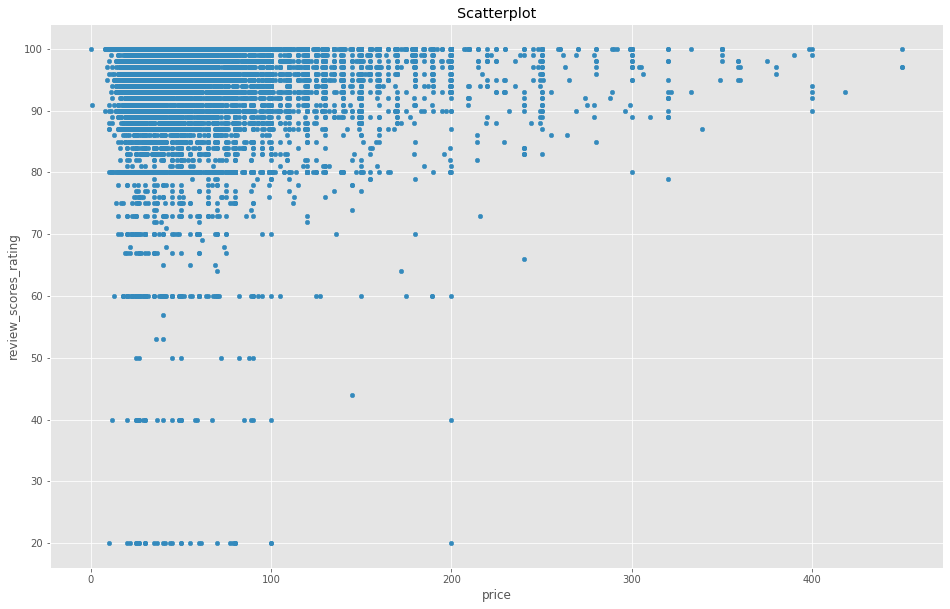

In [17]:
# Define correlation Price vs Raiting
features.plot.scatter(x='price', y='review_scores_rating')
plt.title("Scatterplot")
print(features['price'].corr(features['review_scores_rating']))
plt.savefig('./docs/images/price_rating.png')

0.10431163543140175


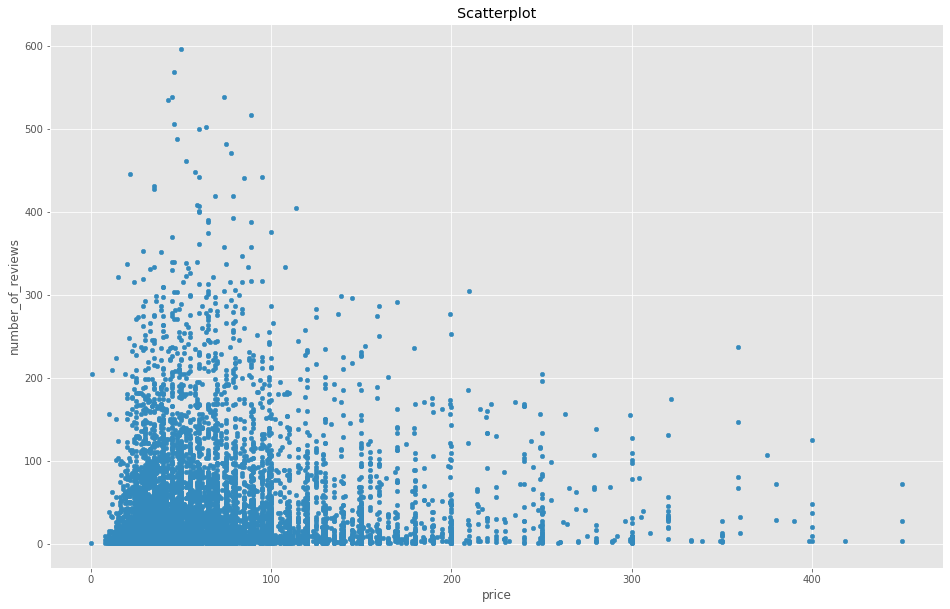

In [18]:
# Define correlation Price and Review numbers
features.plot.scatter(x='price', y='number_of_reviews')
plt.title("Scatterplot")
print(features['price'].corr(features['number_of_reviews']))
plt.savefig('./docs/images/price_review.png')

In [26]:
X = features.drop('price', axis=1)
y = features['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

# Instantiate
lm_model = LinearRegression()

# Fit the model
lm_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
# Predict price
predicted_train_price = lm_model.predict(X_test)

In [28]:
# Rsquared here for comparing test and preds from model
r2_test = r2_score(y_test, predicted_train_price)
r2_test

0.5090744202211779

In [22]:
mse = mean_squared_error(y_test, predicted_train_price)
mse

828.1431127571827

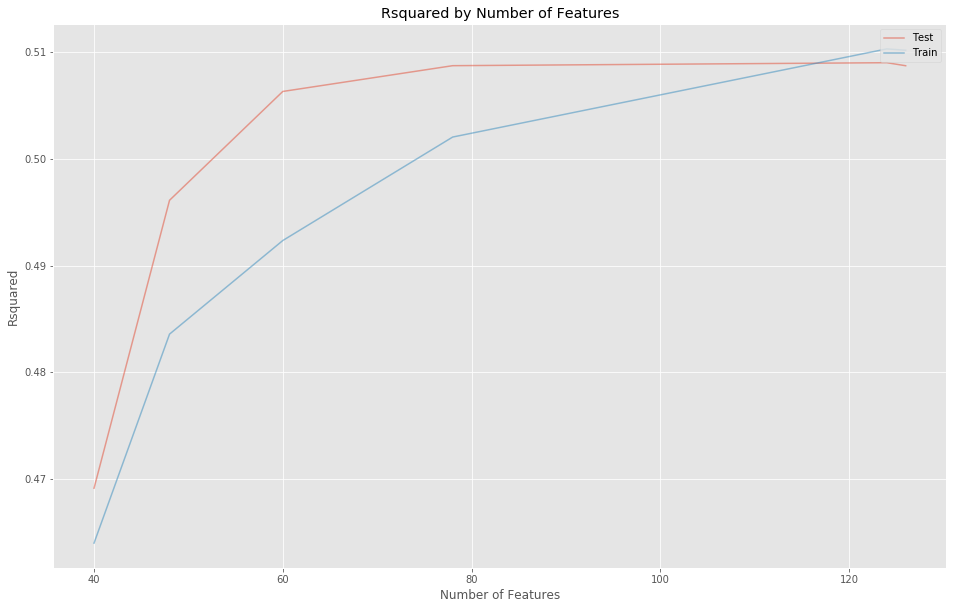

In [23]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

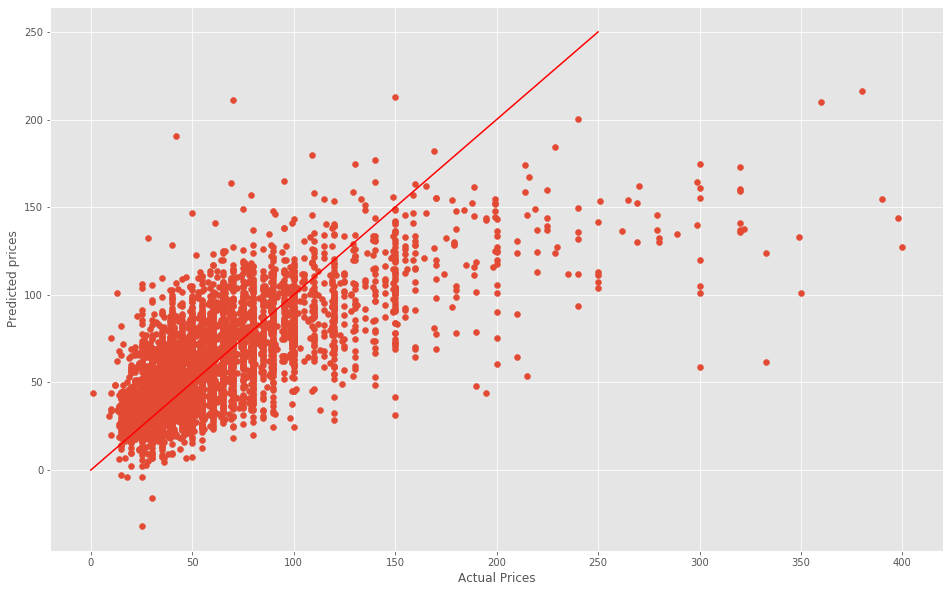

In [24]:
plt.figure(figsize=(16,10))
plt.scatter(y_test, predicted_train_price)
plt.plot([0, 250], [0, 250], 'r-' )
plt.ylabel('Predicted prices')
plt.xlabel('Actual Prices')
plt.savefig('./docs/images/price_prediction.png')

In [29]:
coefs = list(zip(lm_model.coef_, X))
coefs.sort(reverse=True)
coefs

[(22.188143535353632, 'bedrooms'),
 (20.437140784866674, 'Entire home/apt'),
 (11.272499138208058, 'Mitte'),
 (10.299933272222393, 'Friedrichshain-Kreuzberg'),
 (9.937918574473542, 'super_strict_60'),
 (9.597030540880365, 'super_strict_30'),
 (8.877446780941325, 'Indoor fireplace'),
 (8.053808054775923, 'Pankow'),
 (7.821186588327638, 'Air conditioning'),
 (6.631498798042295, 'Wide entrance for guests'),
 (6.516687826137563, 'Babysitter recommendations'),
 (6.46766821701519, 'Neukölln'),
 (6.392679436910555, 'Dryer'),
 (6.367766814160523, 'Elevator'),
 (6.257944288989874, 'Pack ’n Play/travel crib'),
 (5.229189233620857, 'BBQ grill'),
 (5.123848425884538, 'Fire extinguisher'),
 (4.972889645432787, 'Ethernet connection'),
 (4.971902774327663, 'Window guards'),
 (4.760475220182338, 'Private entrance'),
 (4.683987662454049, 'Dishwasher'),
 (4.640634827225837, 'Wide doorway to guest bathroom'),
 (4.5581677980736135, 'TV'),
 (4.499448340946779, 'Extra space around bed'),
 (4.248010373058015

In [30]:
neighborhoods = np.unique(listings['neighbourhood_group_cleansed'])
neighborhood_impact = [i for i in coefs if i[1] in neighborhoods]
neighborhood_impact.sort(reverse=True)

In [31]:
for index, val in neighborhood_impact:
    print(index, val)

11.272499138208058 Mitte
10.299933272222393 Friedrichshain-Kreuzberg
8.053808054775923 Pankow
6.46766821701519 Neukölln
3.9237792134880207 Charlottenburg-Wilm.
3.3896265964351273 Tempelhof - Schöneberg
-1.172078818727968 Lichtenberg
-2.1565214595214393 Treptow - Köpenick
-4.8024327940574825 Steglitz - Zehlendorf
-8.654474840594705 Reinickendorf
-11.761967384633348 Marzahn - Hellersdorf
-14.859839194567014 Spandau


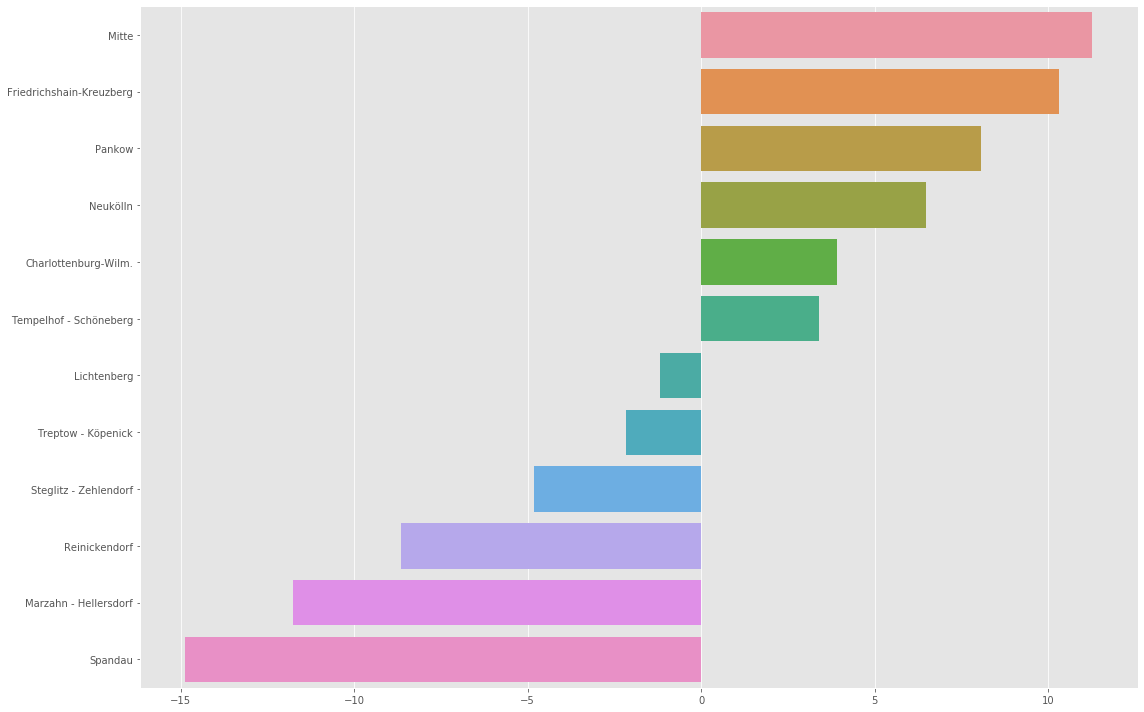

In [32]:
plt.figure(figsize=(16,10))
sns.barplot(x=[n[0] for n in neighborhood_impact], y=[n[1] for n in neighborhood_impact], orient='h')
plt.tight_layout()
plt.savefig('./docs/images/price_loc.png')

### What features have an impact on the price?


In [38]:
imp_features_cleaned = [x for x in coefs if x[0] < -10 or x[0] >5]
imp_features_cleaned

[(22.188143535353632, 'bedrooms'),
 (20.437140784866674, 'Entire home/apt'),
 (11.272499138208058, 'Mitte'),
 (10.299933272222393, 'Friedrichshain-Kreuzberg'),
 (9.937918574473542, 'super_strict_60'),
 (9.597030540880365, 'super_strict_30'),
 (8.877446780941325, 'Indoor fireplace'),
 (8.053808054775923, 'Pankow'),
 (7.821186588327638, 'Air conditioning'),
 (6.631498798042295, 'Wide entrance for guests'),
 (6.516687826137563, 'Babysitter recommendations'),
 (6.46766821701519, 'Neukölln'),
 (6.392679436910555, 'Dryer'),
 (6.367766814160523, 'Elevator'),
 (6.257944288989874, 'Pack ’n Play/travel crib'),
 (5.229189233620857, 'BBQ grill'),
 (5.123848425884538, 'Fire extinguisher'),
 (-11.761967384633348, 'Marzahn - Hellersdorf'),
 (-13.366386905367836, 'Shared room'),
 (-14.859839194567014, 'Spandau')]

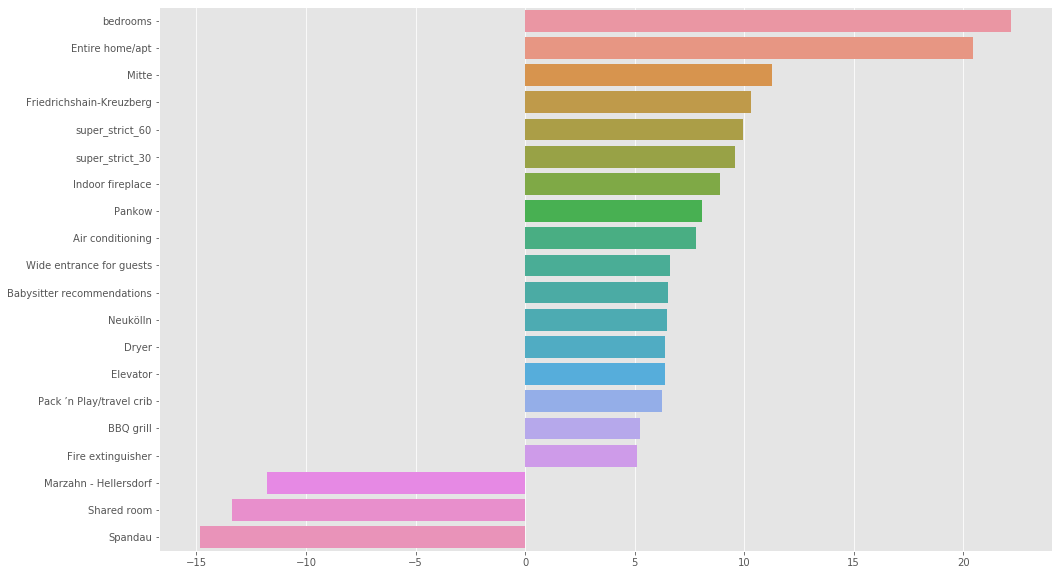

In [36]:

sns.barplot(x=[n[0] for n in imp_features_cleaned], y=[n[1] for n in imp_features_cleaned], orient='h')
plt.savefig('./docs/images/price_features.png')

In [39]:
amenity_impact = [i for i in coefs if i[1] in amenities_filtered]
amenity_impact.sort(reverse=True)
amenity_impact

[(8.877446780941325, 'Indoor fireplace'),
 (7.821186588327638, 'Air conditioning'),
 (6.631498798042295, 'Wide entrance for guests'),
 (6.516687826137563, 'Babysitter recommendations'),
 (6.392679436910555, 'Dryer'),
 (6.367766814160523, 'Elevator'),
 (6.257944288989874, 'Pack ’n Play/travel crib'),
 (5.229189233620857, 'BBQ grill'),
 (5.123848425884538, 'Fire extinguisher'),
 (4.972889645432787, 'Ethernet connection'),
 (4.971902774327663, 'Window guards'),
 (4.760475220182338, 'Private entrance'),
 (4.683987662454049, 'Dishwasher'),
 (4.640634827225837, 'Wide doorway to guest bathroom'),
 (4.5581677980736135, 'TV'),
 (4.499448340946779, 'Extra space around bed'),
 (4.248010373058015, 'Paid parking on premises'),
 (4.029434471804819, 'Paid parking off premises'),
 (4.02786633585349, 'Self check-in'),
 (3.645542265648568, 'Wide clearance to shower'),
 (3.6455422656477525, ' toilet'),
 (3.2696828966051017, 'Crib'),
 (3.0500488755727018, 'Safety card'),
 (2.8371364214505967, 'Patio or ba

In [40]:
cleaned = [x for x in amenity_impact if x[0] < -5 or x[0] >5]
cleaned

[(8.877446780941325, 'Indoor fireplace'),
 (7.821186588327638, 'Air conditioning'),
 (6.631498798042295, 'Wide entrance for guests'),
 (6.516687826137563, 'Babysitter recommendations'),
 (6.392679436910555, 'Dryer'),
 (6.367766814160523, 'Elevator'),
 (6.257944288989874, 'Pack ’n Play/travel crib'),
 (5.229189233620857, 'BBQ grill'),
 (5.123848425884538, 'Fire extinguisher'),
 (-5.379965042161081, 'Lake access'),
 (-6.782532839384179, 'Flat path to guest entrance'),
 (-7.447900487541439, 'Cleaning before checkout')]

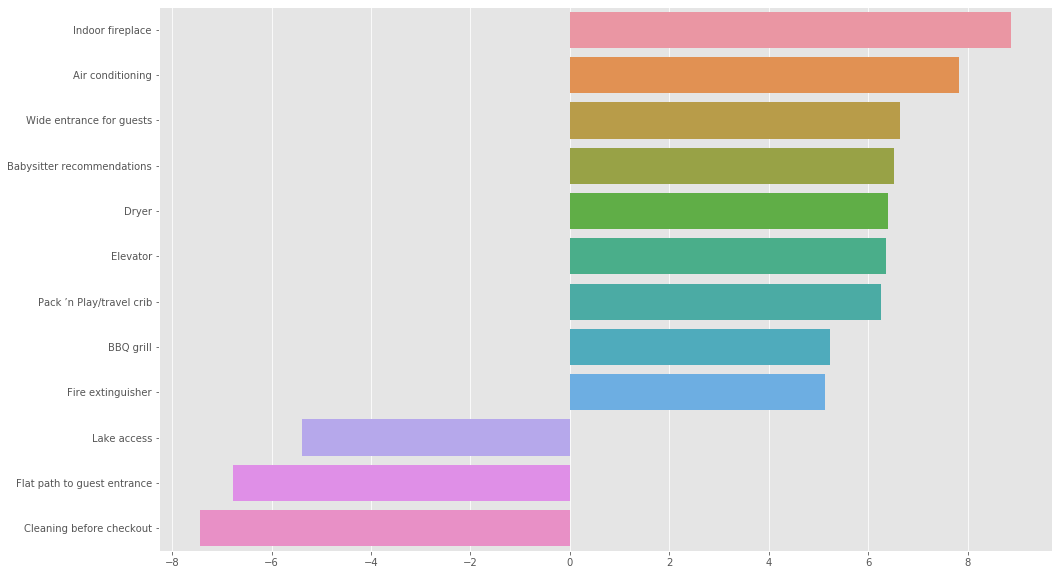

In [41]:
plt.figure(figsize=(16,10))
sns.barplot(x=[n[0] for n in cleaned], y=[n[1] for n in cleaned], orient='h')
plt.savefig('./docs/images/amenities.png')